# Unsupervised Learning -  PCA and Clustering for the UsArrest Dataset


## Exploring the data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import KMeans

import shutup;
shutup.please()

arrests_df = pd.read_csv("UsArrests.csv")
arrests_df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


## Exploratory Data Analysis

### Dataset Cleaning

First we check if there is any missing data in the columns of the dataframe.

In [2]:
# check the shape of the dataframe
arrests_df.shape

(50, 5)

In [3]:
# check the information that the dataframe contains
arrests_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   City      50 non-null     object 
 1   Murder    50 non-null     float64
 2   Assault   50 non-null     int64  
 3   UrbanPop  50 non-null     int64  
 4   Rape      50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


The dataset consists of the data types float, int and object. 

In [4]:
# get the number of missing data points per column
missing = arrests_df.isnull().sum()

missing

City        0
Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

There are no missing data points in this data set.

In [5]:
# get the statistical information of the dataset
arrests_df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


The Assualt column has higher standard deviation and averages values compared to the other columns. This data will have to be scaled in order to get accurate results from the clustering models.

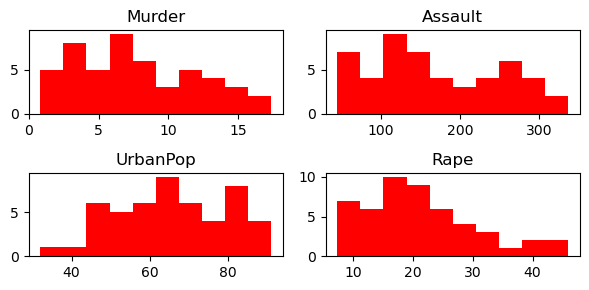

In [6]:
# Plot histograms
histograms = arrests_df.hist(color='red', grid = False, figsize=(6, 3))
plt.tight_layout()
plt.show()

## Correlation Analysis

The City columns is not relevant for the correlation analysis so it can be dropped.

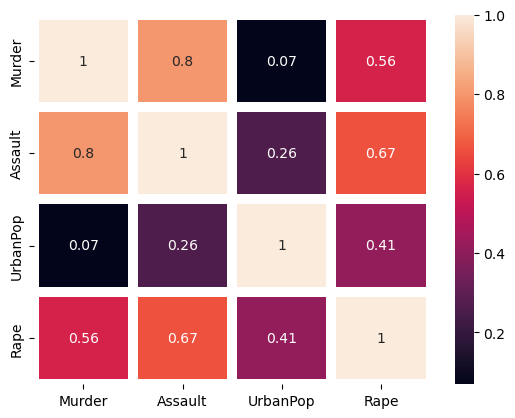

In [7]:
city = arrests_df.City

# correlation coefficient matrix
corr_df = arrests_df.drop(["City"],axis=1).corr()
labels =corr_df.columns

correlations = corr_df.corr()

# heatmap of correlation coefficient
sns.heatmap(corr_df, annot = True, linewidth = 6);

- Assualt and murder have the strongest correlation in the data set and this makes sense because assulat can lead to murder.
- Assualt and Rape have the second strongest correlation, followed by rape and murder.

## PCA

### Unscaled Dataset

This section explores the principal component analysis of both the scaled and unscaled data.

In [8]:
# get the PCA object
pca = PCA() 

# get the unscaled features
X = arrests_df.drop(["City"],axis=1).values

# train the PCA model
X_trans = pca.fit_transform(X)

# PCA dataframe
df_pca = pd.DataFrame(X_trans)
df_pca.head()

,0,1,2,3
0,64.802164,11.448007,-2.494933,2.407901
1,92.827450,17.982943,20.126575,-4.094047
2,124.068216,-8.830403,-1.687448,-4.353685
3,18.340035,16.703911,0.210189,-0.520994
4,107.422953,-22.520070,6.745873,-2.811826


In [9]:
def biplot(score,coeff,labels=None,points=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())

    fig, ax = plt.subplots()    

    ax.scatter(xs * scalex,ys * scaley,s=5)

    for i in range(0,len(xs)):
        txt = city[i]
        ax.annotate(txt, (xs[i]* scalex, ys[i]* scaley))

    for i in range(n):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
            
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

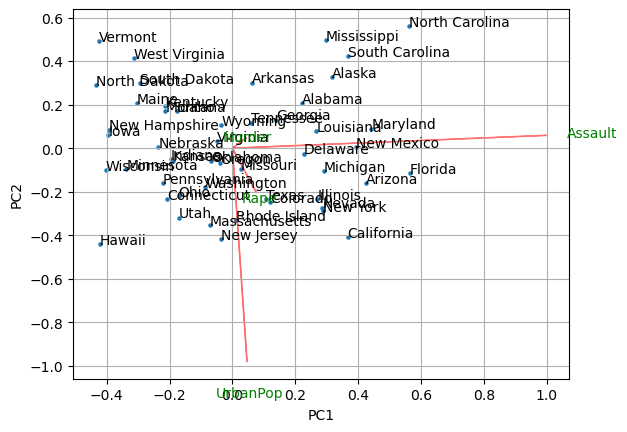

In [10]:
# plotting the biplot
biplot(X_trans[:,0:2],np.transpose(pca.components_[0:2, :]),list(labels),list(city))
plt.show()

The aim of the PCA is to reduce the number of features and this can be done using the biplot. The biplot above shows which features are the most important by the length of the red line. As it can be seen, Assualt and UrbanPop are the most important and Rape and Murder are the least important.

In [11]:
# get the first and second principal components
pc1 = abs( pca.components_[0] )
pc2 = abs( pca.components_[1] )

# create dataframe of features and PCA importance of features
Feature_PCA = pd.DataFrame()

# populate the rows and columns of the dataframe
Feature_PCA["Features"] = list(labels)
Feature_PCA["PC1 Importance"] = pc1
Feature_PCA["PC2 Importance"] = pc2

Feature_PCA

,Features,PC1 Importance,PC2 Importance
0,Murder,0.041704,0.044822
1,Assault,0.995221,0.058760
2,UrbanPop,0.046336,0.976857
3,Rape,0.075156,0.200718


The table above shows a summary of the importance of the features and Assult and a UrbanPop are the most important as predicted by the biplot above.

### Scaled Dataset

Now we look at the PCA for scaled dataset. The dataset was scaled by standardising it using the StandardScaler() function and the table below shows that the data points are now within the same scale compared to the unscaled data.

In [12]:
# standardise the data
X_scaled = StandardScaler().fit_transform(X)

# get the pca object
pca_scaled = PCA() 

# perform PCA on scaled data
X_scaled_pca = pca_scaled.fit_transform(X_scaled)

scaled_pca_df = pd.DataFrame(X_scaled_pca)
scaled_pca_df.head()

,0,1,2,3
0,0.985566,1.133392,-0.444269,0.156267
1,1.950138,1.073213,2.040003,-0.438583
2,1.763164,-0.745957,0.054781,-0.834653
3,-0.141420,1.119797,0.114574,-0.182811
4,2.523980,-1.542934,0.598557,-0.341996


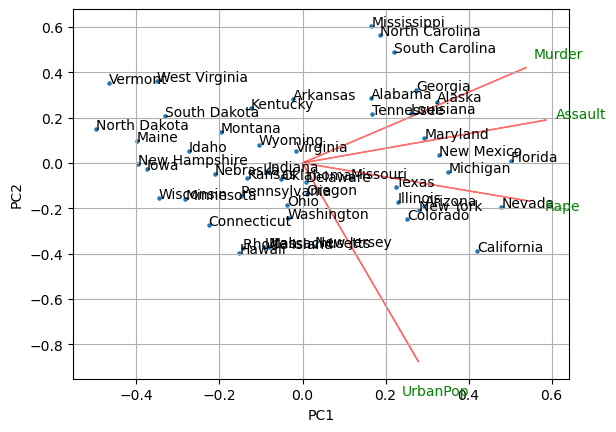

In [13]:
# plotting the biplot
biplot(X_scaled_pca[:,0:2],np.transpose(pca_scaled.components_[0:2, :]),list(labels))
plt.show()

In [14]:
# getting the first and second principal components
pc1 = abs( pca_scaled.components_[0] ) 
pc2 = abs( pca_scaled.components_[1] )

# creating dataframe of features and PCA importance of features
feat_df = pd.DataFrame()

# populating rows and columns of dataframe
Feature_PCA["Features"] = list(labels)
Feature_PCA["PC1 Importance"] = pc1
Feature_PCA["PC2 Importance"] = pc2

# displaying results
Feature_PCA

,Features,PC1 Importance,PC2 Importance
0,Murder,0.535899,0.418181
1,Assault,0.583184,0.187986
2,UrbanPop,0.278191,0.872806
3,Rape,0.543432,0.167319


The biplot above shows a more balanced importance of the features compared to the biplot of the unscaled data. This biplot shows a clear view of which crimes are dominant in cities. For example, Assualt is domanant in Florida, Maryland, New Mexico and Michogan. Rape is more dominant in Nevada, Colorado and etc.

The summary of the features importance above still shows that UrbanPop amd Assualt have high importance compared to the other features. However, Rape and Murder are not far of from the Assualt in the first principal component but UrbanPop is still quite dominant in the second princical component. 

The UrbanPop feature is showing a distinct indepence from the other features for both the scaled and unscaled dataset. This makes sense looking at how it has the weakest correlation with all the features.

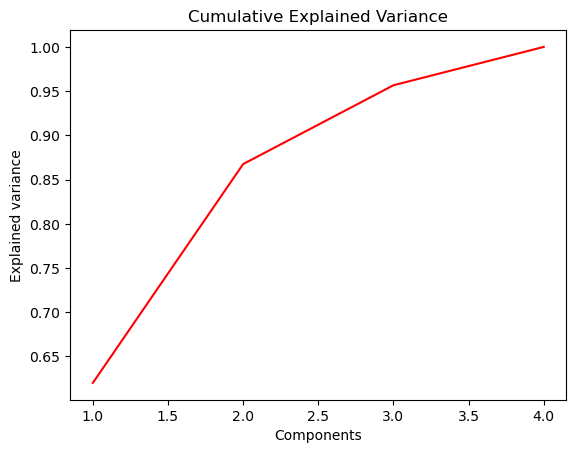

In [15]:
# Cumulative variance plot
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.plot(range(1,len(pca_scaled.explained_variance_ratio_ )+1),
         np.cumsum(pca_scaled.explained_variance_ratio_),
         c='red')
plt.title("Cumulative Explained Variance")
plt.show()

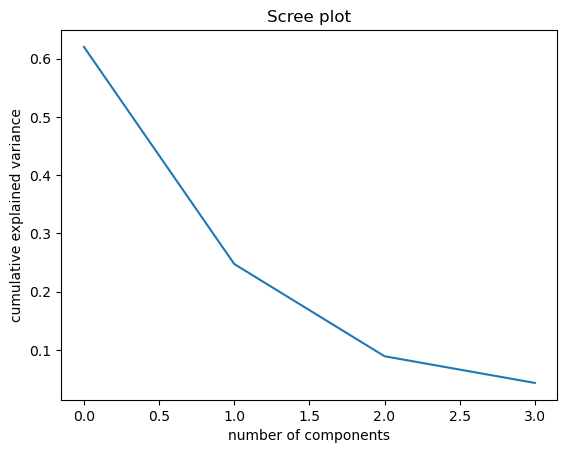

In [16]:
# Scree plot
plt.plot(pca_scaled.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Scree plot")
plt.show()

The first 3 principal components together explain around 90% of the varience,therefore we can use the 3 features to perform clustering. The dimension of the features can be reduced from 4 to 3.

# Clustering

## Hierarchical Clustering

In [17]:
# store the first 3 principal components into a dataframe
pca_df = pd.DataFrame(X_scaled_pca[:,0:3], index = city)
pca_df.head()

,0,1,2
City,,,
Alabama,0.985566,1.133392,-0.444269
Alaska,1.950138,1.073213,2.040003
Arizona,1.763164,-0.745957,0.054781
Arkansas,-0.141420,1.119797,0.114574
California,2.523980,-1.542934,0.598557


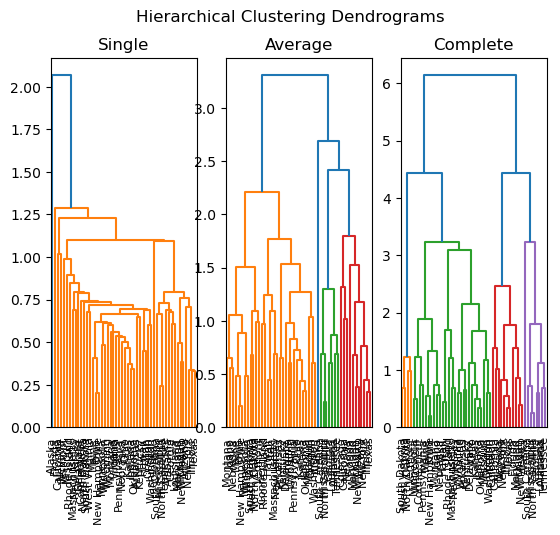

In [18]:
# subplotting dendrograms for 3 methods (single, average and complete)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrograms')

# single method dendrogram
ax1.set_title("Single")
dendrogram(linkage(pca_df, method = 'single'), labels = pca_df.index, ax = ax1)

# average method dendrogram
ax2.set_title("Average")
dendrogram(linkage(pca_df, method = 'average'), labels = pca_df.index, ax = ax2)

# complete method dendrogram
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method = 'complete'), labels = pca_df.index, ax = ax3)


plt.show() # displaying dendrograms

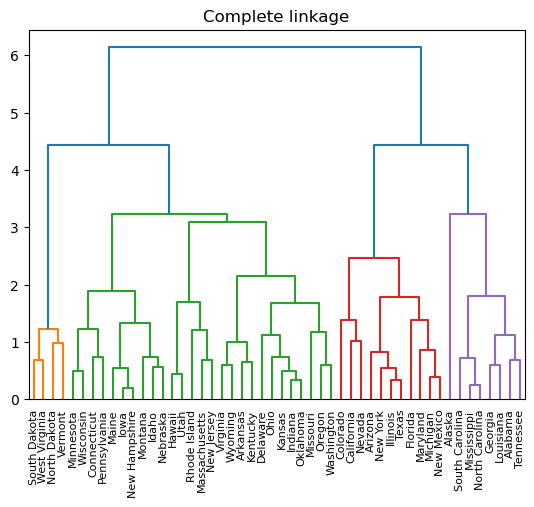

In [19]:
plt.title("Complete linkage")
dendrogram(linkage(pca_df, method = 'complete'), labels = pca_df.index)
plt.show()

The dendrogram above shows 4 clusters and have a significant difference in sizes. The clustering was done based on the number of the crime arrests in the cities. The purple is Murder dominant, red is Rape dominant, green is UrbanPop and orange is Assualt dominant. The cities with the lowest number if crimes are the ones in orange.

## K-Means Clustering

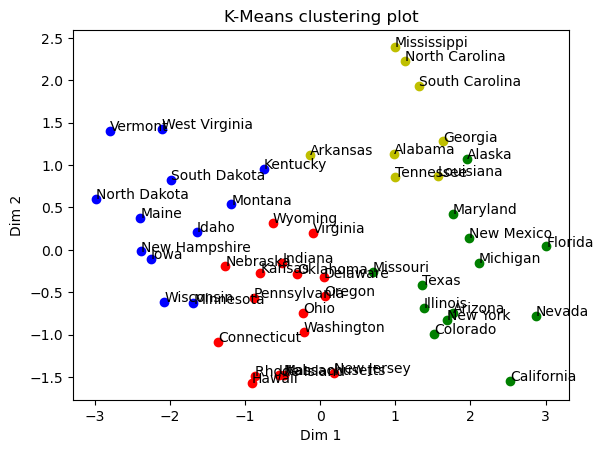

In [20]:
# Extracting the first two components
x = X_scaled_pca[:,0]
y = X_scaled_pca[:,1]

# Fit k-means
k = 4

# k-means clustering model
kmeans = KMeans(n_clusters = k, init = 'k-means++')
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'

for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        text = city[i]
        ax.annotate(text, (x[i], y[i]))
        
ax.set_title("K-Means clustering plot")
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
plt.show()

The K-Means clustering model has clustered the cities in 4 clusters, based on the concentration of the numbers of crime arrests.